#### This notebook analyses the horizontally-averaged vertical heat budget in the abrupt ACCESS-OM2 experiments.

In [1]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram
from dask.distributed import Client
from collections import OrderedDict


%matplotlib inline

In [2]:
client = Client(n_workers=8)
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40871/status,
Dashboard: /proxy/40871/status,Workers: 8
Total threads: 8,Total memory: 80.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40281,Workers: 8
Dashboard: /proxy/40871/status,Total threads: 8
Started: Just now,Total memory: 80.00 GiB
Comm: tcp://127.0.0.1:44823,Total threads: 1
Dashboard: /proxy/43947/status,Memory: 10.00 GiB
Nanny: tcp://127.0.0.1:37359,


In [3]:
### Generate new session

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'
session = cc.database.create_session(db)

# cc.querying.get_experiments(session)

In [43]:
def vertical_heat_budget(expt):
    ds = xr.open_mfdataset(paths=f'/scratch/e14/mp2135/access-om2/archive/{expt}/output1*/ocean/ocean_heat.nc', 
                            combine='by_coords')
    area = xr.open_mfdataset(paths=f'/scratch/e14/mp2135/access-om2/archive/{expt}/output1*/ocean/ocean_grid.nc', 
                            combine='by_coords').area_t.mean(dim='time')
    
    # Tendency
    temp_tendency = ds.temp_tendency
    
    # Advection
    adv = ds.temp_advection
    neutral_gm_temp = ds.neutral_gm_temp
    temp_submeso = ds.temp_submeso
    
    # Vertical mixing
    temp_vdiffuse_diff_cbt = ds.temp_vdiffuse_diff_cbt
    temp_nonlocal_KPP = ds.temp_nonlocal_KPP
    mixdownslope_temp = ds.mixdownslope_temp
    temp_sigma_diff = ds.temp_sigma_diff
    
    # Isopycnal mixing
    neutral_diffusion_temp = ds.neutral_diffusion_temp
    temp_vdiffuse_k33 = ds.temp_vdiffuse_k33
    
    # Surface forcing
    sw_heat = ds.sw_heat
    frazil_3d = ds.frazil_3d
    temp_rivermix = ds.temp_rivermix
    temp_vdiffuse_sbc = ds.temp_vdiffuse_sbc
    
    
    def integrate_variable(variable):
        seconds_in_month = ds.time.dt.days_in_month * 86400
        #return (variable * area).sum('xt_ocean').sum('yt_ocean').mean(dim='time').cumsum('st_ocean') # time mean
        return ((variable * area).sum('xt_ocean').sum('yt_ocean').cumsum('st_ocean') * seconds_in_month).cumsum('time').isel(time=-1) # time integral
    
    # all temp_tendency variables are multipled by dzt, hence no need to do so in the cumsum
    
    
    tendency = integrate_variable(temp_tendency).load()
    advection = integrate_variable(adv + neutral_gm_temp + temp_submeso).load()
    vertical_mixing = integrate_variable(temp_vdiffuse_diff_cbt + temp_nonlocal_KPP + mixdownslope_temp + temp_sigma_diff).load()
    isopycnal_mixing = integrate_variable(neutral_diffusion_temp + temp_vdiffuse_k33).load()
    surface_forcing = integrate_variable(sw_heat + frazil_3d + temp_rivermix + temp_vdiffuse_sbc).load()
    
    
    return tendency, advection, vertical_mixing, isopycnal_mixing, surface_forcing

In [44]:
def nonlinearity_metric(cont, cool, warm):
    cool_anom = cool - cont
    warm_anom = warm - cont
    ave_anom = 0.5 * (-1*cool_anom + warm_anom)
    diff_anom = cool_anom + warm_anom
    
    return diff_anom / ave_anom

In [23]:
def plot_heat_budget(heat_budget_components):
    plt.plot(heat_budget_components[0].sel(st_ocean=slice(None,depth)), z, label='tendency')
    plt.plot(heat_budget_components[1].sel(st_ocean=slice(None,depth)), z, label='advection')
    plt.plot(heat_budget_components[2].sel(st_ocean=slice(None,depth)), z, label='vertical mixing')
    plt.plot(heat_budget_components[3].sel(st_ocean=slice(None,depth)), z, label='isopycnal mixing')
    plt.plot(heat_budget_components[4].sel(st_ocean=slice(None,depth)), z, label='surface forcing')

In [24]:
yr_beg = '2400-02-01'

expt = '1deg_jra55_ryf_cont_heatbudgetdiags'
heat_budget_cont = vertical_heat_budget(expt)

In [25]:
yr_beg = '2400-02-01'

expt = '1deg_jra55_ryf_cool_x1_heatbudgetdiags'
heat_budget_cool = vertical_heat_budget(expt)

In [26]:
yr_beg = '2400-02-01'

expt = '1deg_jra55_ryf_warm_x1_heatbudgetdiags'
heat_budget_warm = vertical_heat_budget(expt)

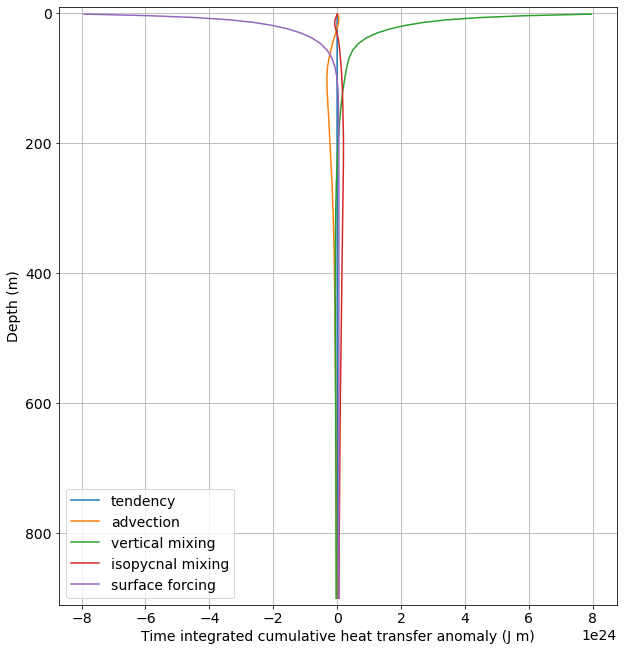

In [31]:
plt.figure(figsize=(10,11))

depth = 1000
z = heat_budget_cont[0].st_ocean.sel(st_ocean=slice(None,depth))

plot_heat_budget(heat_budget_cont)

fontsize=14
plt.legend(fontsize=fontsize)
plt.grid()
plt.ylim(-10, z.max()+10)
plt.xlabel('Time integrated cumulative heat transfer anomaly (J m)', fontsize=fontsize)
plt.ylabel('Depth (m)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.rc('font', size=fontsize)

plt.gca().invert_yaxis()

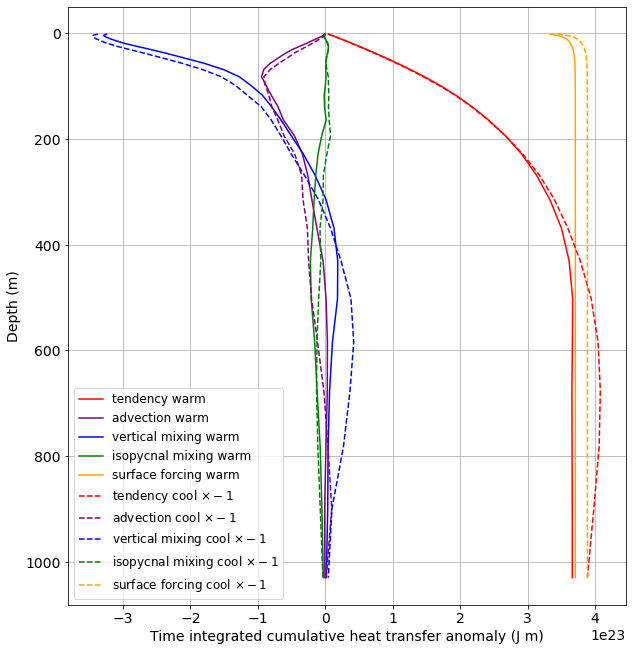

In [41]:
fig, ax = plt.subplots(figsize=(10,11))

depth = 1150
z = heat_budget_cont[0].st_ocean.sel(st_ocean=slice(None,depth))

plt.plot((heat_budget_warm[0] - heat_budget_cont[0]).sel(st_ocean=slice(None,depth)), z, label='tendency warm', color='red')
plt.plot((heat_budget_warm[1] - heat_budget_cont[1]).sel(st_ocean=slice(None,depth)), z, label='advection warm', color='purple')
plt.plot((heat_budget_warm[2] - heat_budget_cont[2]).sel(st_ocean=slice(None,depth)), z, label='vertical mixing warm', color='blue')
plt.plot((heat_budget_warm[3] - heat_budget_cont[3]).sel(st_ocean=slice(None,depth)), z, label='isopycnal mixing warm', color='green')
plt.plot((heat_budget_warm[4] - heat_budget_cont[4]).sel(st_ocean=slice(None,depth)), z, label='surface forcing warm', color='orange')

plt.plot(-1*(heat_budget_cool[0] - heat_budget_cont[0]).sel(st_ocean=slice(None,depth)), z, label=r'tendency cool $\times -1$', color='red', linestyle='--')
plt.plot(-1*(heat_budget_cool[1] - heat_budget_cont[1]).sel(st_ocean=slice(None,depth)), z, label=r'advection cool $\times -1$', color='purple', linestyle='--')
plt.plot(-1*(heat_budget_cool[2] - heat_budget_cont[2]).sel(st_ocean=slice(None,depth)), z, label=r'vertical mixing cool $\times -1$', color='blue', linestyle='--')
plt.plot(-1*(heat_budget_cool[3] - heat_budget_cont[3]).sel(st_ocean=slice(None,depth)), z, label=r'isopycnal mixing cool $\times -1$', color='green', linestyle='--')
plt.plot(-1*(heat_budget_cool[4] - heat_budget_cont[4]).sel(st_ocean=slice(None,depth)), z, label=r'surface forcing cool $\times -1$', color='orange', linestyle='--')

fontsize=14
plt.legend(fontsize=fontsize-2)
plt.grid()
# plt.ylim(None, z.max()+10)
plt.xlabel('Time integrated cumulative heat transfer anomaly (J m)', fontsize=fontsize)
plt.ylabel('Depth (m)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.rc('font', size=fontsize)

plt.gca().invert_yaxis()

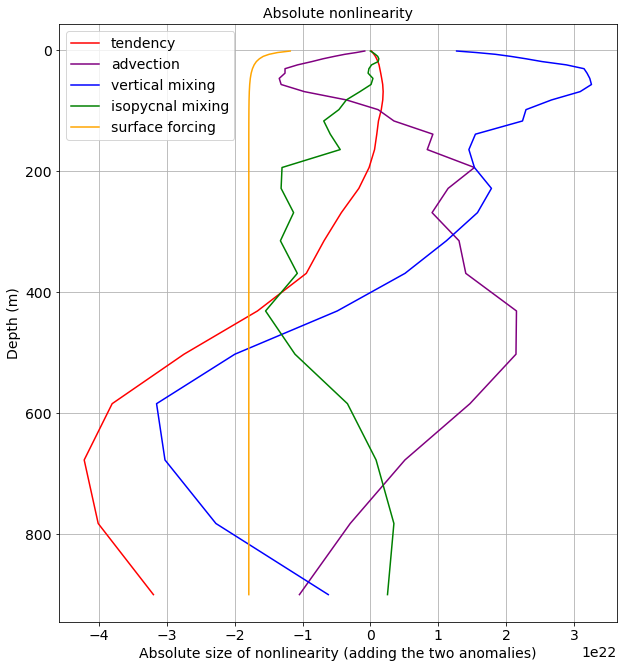

In [47]:
plt.figure(figsize=(10,11))

depth = 1000
z = heat_budget_cont[0].st_ocean.sel(st_ocean=slice(None,depth))

# plt.plot(nonlinearity_metric(heat_budget_cont[0], heat_budget_cool[0], heat_budget_warm[0]).sel(st_ocean=slice(None,depth)), z, label='tendency', color='red')
# plt.plot(nonlinearity_metric(heat_budget_cont[1], heat_budget_cool[1], heat_budget_warm[1]).sel(st_ocean=slice(None,depth)), z, label='advection', color='purple')
# plt.plot(nonlinearity_metric(heat_budget_cont[2], heat_budget_cool[2], heat_budget_warm[2]).sel(st_ocean=slice(None,depth)), z, label='vertical mixing', color='blue')
# plt.plot(nonlinearity_metric(heat_budget_cont[3], heat_budget_cool[3], heat_budget_warm[3]).sel(st_ocean=slice(None,depth)), z, label='isopycnal mixing', color='green')
# plt.plot(nonlinearity_metric(heat_budget_cont[4], heat_budget_cool[4], heat_budget_warm[4]).sel(st_ocean=slice(None,depth)), z, label='surface forcing', color='orange')

plt.plot((heat_budget_cool[0] + heat_budget_warm[0]  - 2*heat_budget_cont[0]).sel(st_ocean=slice(None,depth)), z, label='tendency', color='red')
plt.plot((heat_budget_cool[1] + heat_budget_warm[1]  - 2*heat_budget_cont[1]).sel(st_ocean=slice(None,depth)), z, label='advection', color='purple')
plt.plot((heat_budget_cool[2] + heat_budget_warm[2]  - 2*heat_budget_cont[2]).sel(st_ocean=slice(None,depth)), z, label='vertical mixing', color='blue')
plt.plot((heat_budget_cool[3] + heat_budget_warm[3]  - 2*heat_budget_cont[3]).sel(st_ocean=slice(None,depth)), z, label='isopycnal mixing', color='green')
plt.plot((heat_budget_cool[4] + heat_budget_warm[4]  - 2*heat_budget_cont[4]).sel(st_ocean=slice(None,depth)), z, label='surface forcing', color='orange')

fontsize=14
plt.title('Absolute nonlinearity', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid()
# plt.xlabel('Fractional size of nonlinearity', fontsize=fontsize)
plt.xlabel('Absolute size of nonlinearity (adding the two anomalies)', fontsize=fontsize)
plt.ylabel('Depth (m)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.gca().invert_yaxis()